In [13]:
# General
import numpy as np
import pandas as pd
import os
import jumpmodels.utils

# For loading data
from feature import DataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd 

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret

In [21]:
# Import data
# -------------------------

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\index_data"
file_path = os.path.join(directory, "full_returns.csv")

## Load the full returns dataset
#full_returns = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
#full_returns = full_returns.dropna() # Remove NaN rows (since markets were closed)
## Select a target return series for financial anchoring (e.g., first factor)
#ret_ser = full_returns.iloc[:, 0]  # First column as reference return series

# Use DataLoader to generate features
data = DataLoader(file_path=file_path).load(start_date="2002-05-30", end_date="2025-02-24")
data.X = data.X.dropna()
data.ret_ser = data.ret_ser.dropna()

print("Daily returns:", data.ret_ser)
print("Engineered features:", data.X)

# Compute cumulative returns
#cumulative_returns = (1 + full_returns).cumprod()

# Plot cumulative returns
#plot_cumret(full_returns)
#plt.show()


Daily returns: Date
2002-05-30    0.003827
2002-05-31   -0.005607
2002-06-03   -0.030221
2002-06-04    0.007441
2002-06-05    0.012235
                ...   
2025-02-18   -0.000096
2025-02-19    0.000360
2025-02-20   -0.005282
2025-02-21   -0.022690
2025-02-24   -0.010225
Name: IWF, Length: 5722, dtype: float64
Engineered features:                ret_5  DD-log_5  sortino_5    ret_20  DD-log_20  sortino_20    ret_60  DD-log_60  sortino_60
Date                                                                                                       
2002-05-30  0.003827      -inf        inf  0.003827       -inf         inf  0.003827       -inf         inf
2002-05-31 -0.001216 -5.496935  -0.296640 -0.000971  -5.521803   -0.242913 -0.000917  -5.527513   -0.230600
2002-06-03 -0.012251 -3.967661  -0.647599 -0.011061  -4.015058   -0.613064 -0.010798  -4.026057   -0.605103
2002-06-04 -0.006262 -4.148951  -0.396816 -0.006192  -4.167739   -0.399820 -0.006159  -4.172805   -0.399681
2002-06-05 -0.0014

In [27]:
# Check for NaN values
print("NaN values per column:")
print(X_train.isna().sum())

# Check for infinite values
print("\nInfinite values per column:")
print(np.isinf(X_train).sum())

# Find extremely large values (greater than 1e10)
large_values_mask = (np.abs(X_train) > 1e10)
print("\nNumber of extremely large values per column:")
print(large_values_mask.sum())

# Print specific rows with large values
if large_values_mask.any().any():
    print("\nRows containing large values:")
    print(X_train[large_values_mask.any(axis=1)])


NaN values per column:
ret_5         0
DD-log_5      0
sortino_5     0
ret_20        0
DD-log_20     0
sortino_20    0
ret_60        0
DD-log_60     0
sortino_60    0
dtype: int64

Infinite values per column:
ret_5         0
DD-log_5      1
sortino_5     1
ret_20        0
DD-log_20     1
sortino_20    1
ret_60        0
DD-log_60     1
sortino_60    1
dtype: int64

Number of extremely large values per column:
ret_5         0
DD-log_5      1
sortino_5     1
ret_20        0
DD-log_20     1
sortino_20    1
ret_60        0
DD-log_60     1
sortino_60    1
dtype: int64

Rows containing large values:
               ret_5  DD-log_5  sortino_5    ret_20  DD-log_20  sortino_20    ret_60  DD-log_60  sortino_60
Date                                                                                                       
2002-05-30  0.003827      -inf        inf  0.003827       -inf         inf  0.003827       -inf         inf


In [31]:
# Train/test split
# -------------------------

train_start, test_start = "2002-05-31", "2022-01-01"
# filter dates
X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(data.X, start_date=test_start)
# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

# Preprocessing
# -------------------------

# Clip the data within 3 standard deviations to mitigate the impact of outliers and standardize the clipped data (zero mean and unit variance)
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

Training starts at: 2002-05-31 00:00:00 and ends at: 2021-12-31 00:00:00
Testing starts at: 2022-01-03 00:00:00 and ends at: 2025-02-24 00:00:00


In [51]:
# -------------------------
# Cross-validation for max_feats and jump_penalty
# -------------------------

# Parallel cross-validation for max_feats and jump_penalty
def fit_and_score(lam, kappa, X, ret_ser, n_components):
    max_feats = kappa ** 2
    model = SparseJumpModel(n_components=n_components, max_feats=max_feats, jump_penalty=lam, cont=False, max_iter=10)
    model.fit(X, ret_ser, sort_by="cumret")
    predicted_states = model.predict(X)
    score = best_model.score(X_train_processed, ret_ser)
    return model, score, (max_feats, lam)

In [53]:
# -------------------------
# Fit the Sparse Jump Model
# -------------------------

# Run parallel cross-validation
results = Parallel(n_jobs=4)(  # Use 4 cores
    delayed(fit_and_score)(lam, kappa, X_train_processed, data.ret_ser, 2)
    for lam in np.logspace(0, 2, 5)  # Reduced lambda values
    for kappa in np.linspace(1, np.sqrt(X_train_processed.shape[1]), 5)  # Reduced kappa values
)

# Get the best model
best_model, best_score, best_params = max(results, key=lambda x: x[1])
max_feats_best, jump_penalty_best = best_params

# Predict and plot with best model
predicted_states = best_model.predict(X_train_processed)
ax, ax2 = plot_regimes_and_cumret(predicted_states, data.ret_ser)
ax.set(title=f"Best SJM ($\\lambda$={jump_penalty_best}, $\\kappa^2$={max_feats_best})")
plt.show()

# Print selected parameters
print(f"Best max_feats: {max_feats_best}, Best jump_penalty: {jump_penalty_best}")

AttributeError: 'SparseJumpModel' object has no attribute 'score'

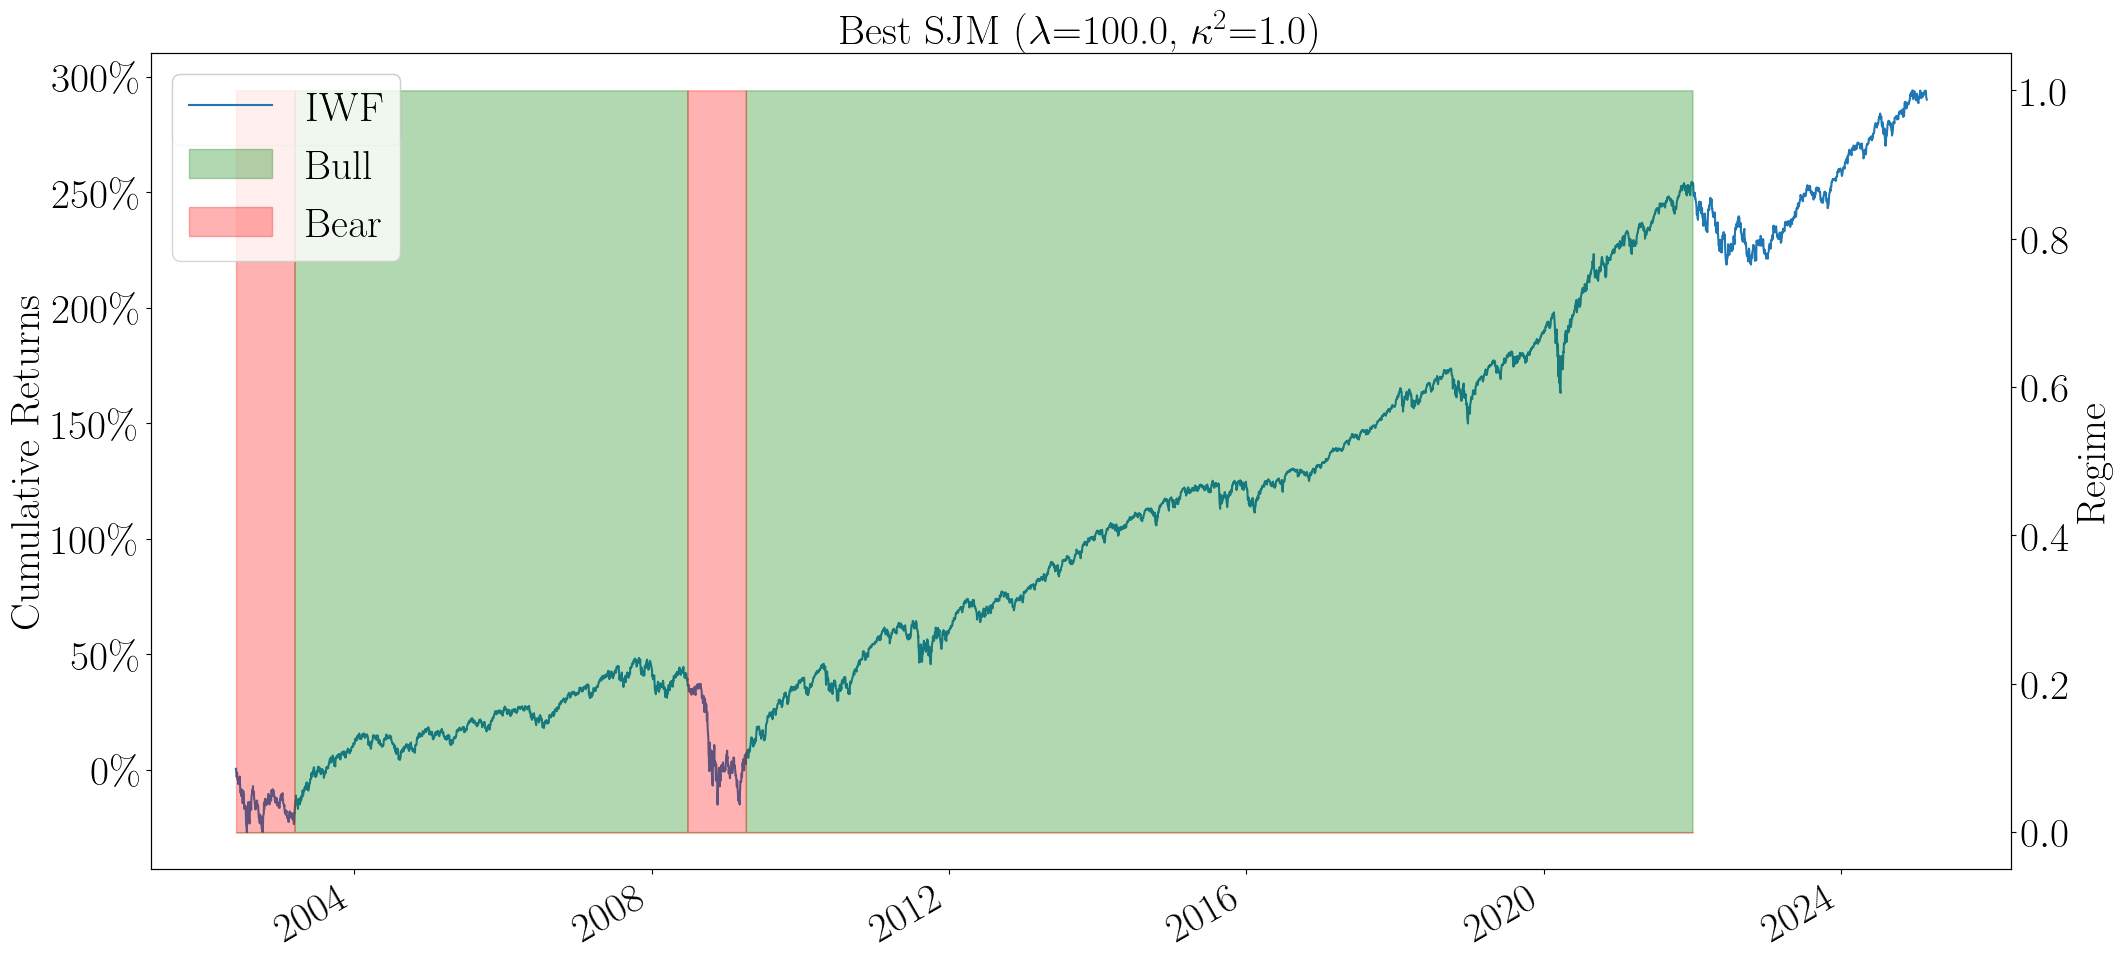

Best max_feats: 1.0, Best jump_penalty: 100.0


In [41]:
# Predict and plot with best model
predicted_states = best_model.predict(X_train_processed)
ax, ax2 = plot_regimes_and_cumret(predicted_states, data.ret_ser)
ax.set(title=f"Best SJM ($\\lambda$={jump_penalty_best}, $\\kappa^2$={max_feats_best})")
plt.show()

# Print selected parameters
print(f"Best max_feats: {max_feats_best}, Best jump_penalty: {jump_penalty_best}")

In [45]:
print("\n\n".join(In[i] for i in range(1, len(In))))


import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import jumpmodels.utils
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from feature import DataLoader

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\index_data"
file_path = os.path.join(directory, "full_returns.csv")

## Load the full returns dataset
#full_returns = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
#full_returns = full_returns.dropna() # Remove NaN rows (since markets were closed)
## Select a target return series for financial anchoring (e.g., first factor)
#ret_ser = full_returns.iloc[:, 0]  # First column as reference return series

# Use DataLoader to generate features
data = DataLoader(file_path=file_path).load(start_date="2002-0